# Clase 4. Preparación de datos. Missing Values

Vamos a tomar el dataset propuesto en la clase

In [165]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Imputación de valores
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Escala de valores
from sklearn.preprocessing import StandardScaler

# Esquemas de entrenamiento
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold
from sklearn.model_selection import cross_val_score

np.random.seed(42)

# Versiones de librerías
print("".join(f"{x[0]}:{x[1]}\n" for x in [
    ("Pandas",pd.__version__),
    ("Numpy",np.__version__),
    ("Matplotlib",matplotlib.__version__),
    ("SKlearn",sklearn.__version__),
    ("Seaborn",sns.__version__)
]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Pandas:1.3.5
Numpy:1.23.2
Matplotlib:3.5.3
SKlearn:1.1.2
Seaborn:0.12.0



## Cargamos el dataset.

para evitar inconvenientes vamos a tomar el archivo directamente desde un csv publico en google

In [166]:
df_cc = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vT4Fd8eecSw3Z5l4sumy90abQ1wnluFn7V0ypux_ALt8sIF9IooO744Bv7LiFta80McKkyOJfmrNBYi/pub?gid=1717860291&single=true&output=csv")
df_cc.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,NaN,0.0,NaN,4.5200,0.033270,124.983300,yes,no,NaN,54.0,1.0,12.0
1,yes,0.0,33.25000,2.4200,0.005217,9.854167,no,no,3.0,34.0,1.0,13.0
2,yes,0.0,33.66667,4.5000,0.004156,15.000000,yes,NaN,4.0,58.0,1.0,5.0
3,yes,0.0,30.50000,2.5400,0.065214,137.869200,no,no,0.0,25.0,1.0,7.0
4,yes,0.0,32.16667,9.7867,0.067051,546.503300,yes,no,2.0,64.0,1.0,5.0


Aquí podemos ver que el dataset tiene las siguientes caracterísiticas:

- Variables de respuesta:
    - ***Card***: Variable ***target*** categórica

- Variables regresoras (Features):
    - Variables Categóricas:
        - ***onwer***: Variable booleana
        - ***selfemp***: Variable booleana
    - Variables Numéricas:
        - ***reports***
        - ***age***
        - ***income***
        - ***share***
        - ***expenditure***
        - ***dependents***
        - ***months***
        - ***majorcards***
        - ***active***


In [167]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

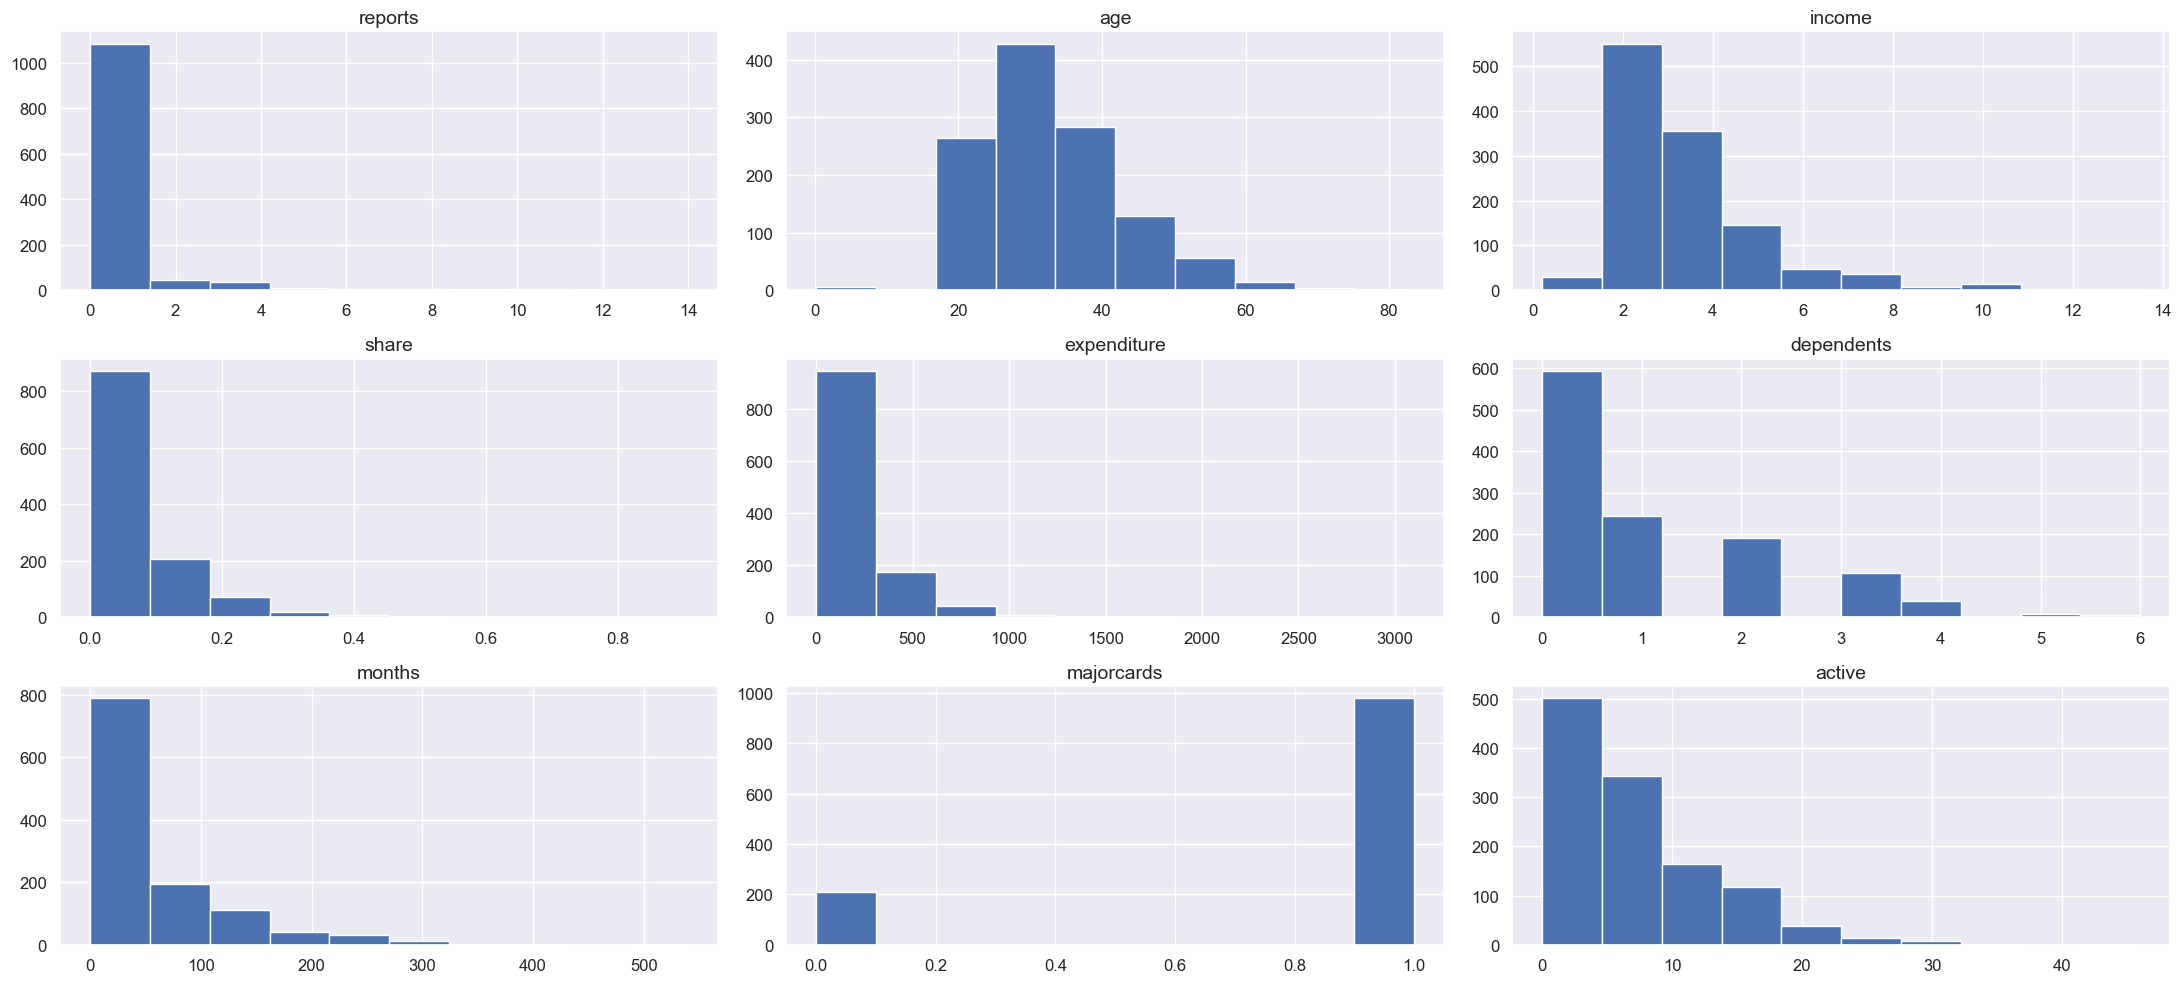

In [168]:
display_dataset_distributions(df_cc)

# 1. Imputación de datos faltantes (Estadístico)

Primeramente vamos a analizar la variable target que no debería tener valores nulos.

In [169]:
# columna Target tiene nulos?
len(df_cc[df_cc['card'].isna()])

131

Dado que tenemos nulos, vamos a filtrar un subconjunto de valores que sabemos que la variable target es NO nula. A partir de esto vemos el número de valores nulos en cada columna

In [170]:
# Ahora vemos el resto de las columnas
df_cc = df_cc[df_cc['card'].notna()]
df_cc.isnull().sum()/len(df_cc)

card           0.000000
reports        0.102694
age            0.106061
income         0.101852
share          0.095960
expenditure    0.101852
owner          0.100168
selfemp        0.102694
dependents     0.000000
months         0.102694
majorcards     0.094276
active         0.100168
dtype: float64

Podemos ver en este caso que estamos en el límite de lo que vimos en clase como la cantidad de valores nulos que soportamos. Para nuestro análisis vamos a continuar asumiendo que 10% es un número aceptable (En la práctica tenemos que hacer un par de validaciones extras)

In [171]:
target = ['card']
categorical_features = ['owner'	, 'selfemp']
numerical_features = ['reports', 'age', 'income', 'share', 'expenditure', 'dependents', 'months', 'majorcards']

### 1.0 Preprocesamos los datos

Dado que tenemos variables que son categóricas vamos a plantear un mapeo muy sencillo a las variables booleanas en 0 y 1.

In [172]:
mapping_dict = {'yes': 1, 'no': 0}

df_cc.card = df_cc.card.map(mapping_dict)
df_cc[categorical_features] = df_cc[categorical_features].applymap(lambda x: mapping_dict.get(x))

df_cc.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
1,1,0.0,33.25000,2.4200,0.005217,9.854167,0.0,0.0,3.0,34.0,1.0,13.0
2,1,0.0,33.66667,4.5000,0.004156,15.000000,1.0,NaN,4.0,58.0,1.0,5.0
3,1,0.0,30.50000,2.5400,0.065214,137.869200,0.0,0.0,0.0,25.0,1.0,7.0
4,1,0.0,32.16667,9.7867,0.067051,546.503300,1.0,0.0,2.0,64.0,1.0,5.0
5,1,0.0,23.25000,2.5000,0.044438,NaN,0.0,0.0,0.0,54.0,1.0,1.0


### 1.1 Imputación estadística 

Para nuestro caso vamos a armar dos pipelines, uno categórico que hara imputación por mediana y otro categórico que trabaje con valor más frecuente.

In [173]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [174]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

In [175]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression())])

In [176]:
X = df_cc[numerical_features + categorical_features]
y = df_cc[target]

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

c:\Users\pablo.nahuel.pelli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['reports', 'age', 'income',
                                                   'share', 'expenditure',
                                                   'dependents', 'months',
                                                   'majorcards']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['owner', 'selfemp'])])),
                ('classifier', LogisticRegression())])

In [178]:
y_pred = model.predict(X_test)

In [179]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83        55
           1       0.95      0.95      0.95       183

    accuracy                           0.92       238
   macro avg       0.89      0.88      0.89       238
weighted avg       0.92      0.92      0.92       238



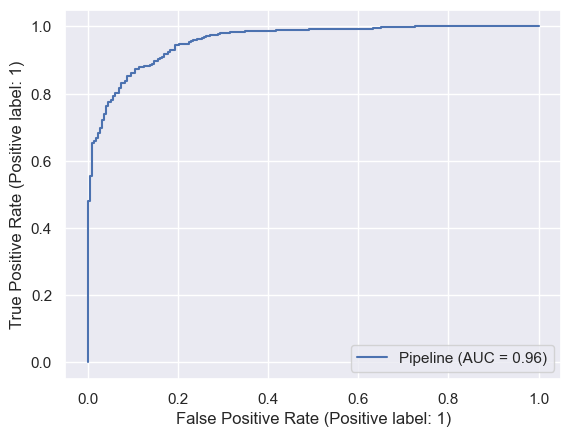

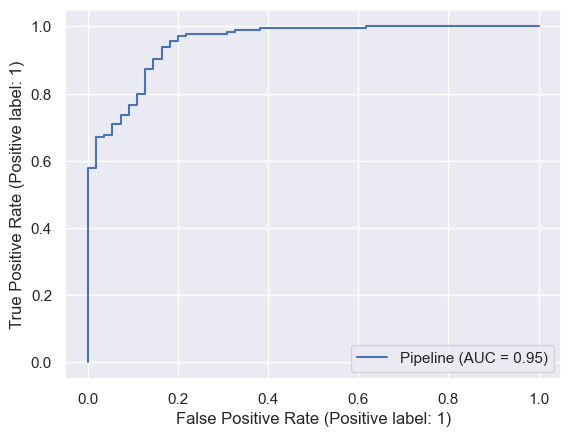

In [180]:
RocCurveDisplay.from_estimator(model, X_train, y_train)
RocCurveDisplay.from_estimator(model, X_test, y_test)

In [189]:
results = []

param_grid = {
    "imputer__strategy": ['most_frequent', 'mean','constant','median' ],
    "lr__max_iter": [1000]
}

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [190]:
for param in param_grid["imputer__strategy"]:

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=param)),
        ('scaler', StandardScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    results.append(scores)


Text(0.5, 1.0, 'SimpleImputer métodos (Training)')

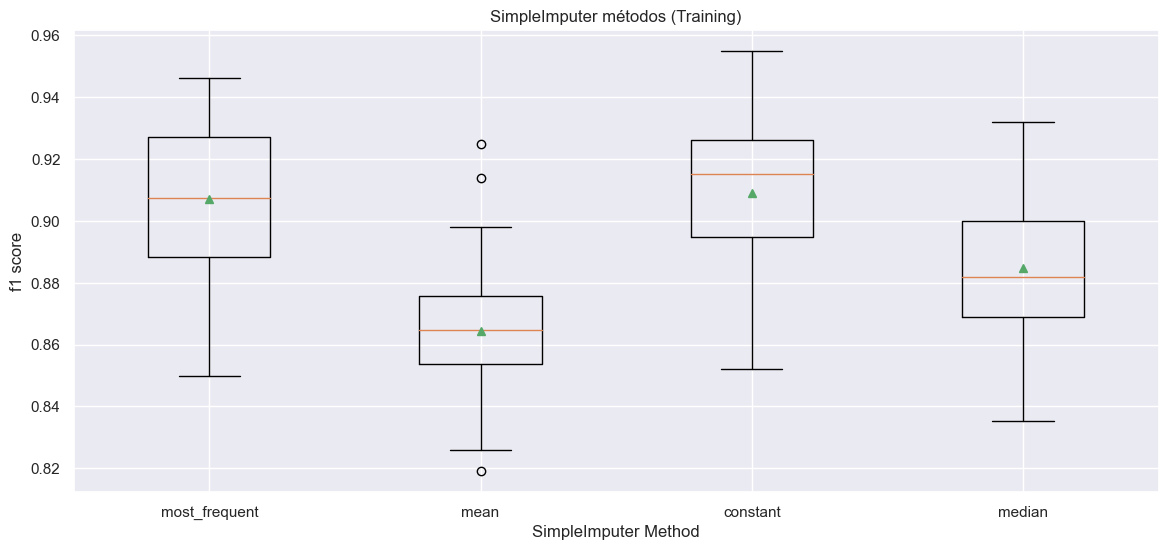

In [191]:
fig, axes = plt.subplots(1, figsize=(14, 6))
axes.boxplot(results, labels=[
             x or "None" for x in param_grid["imputer__strategy"]], showmeans=True)
axes.set_xlabel("SimpleImputer Method")
axes.set_ylabel("f1 score")
axes.set_title("SimpleImputer métodos (Training)")

# 2. Imputador iterativo (MICE)

Para este caso vamos a rearmar un poco el pipeline como lo venimos utilizando. En este caso nuevamente nos interesa ver como cambia el resultado cambiando la cantidad de features a considerar en MICE

In [212]:
results = []

param_grid = {
    "imputer__n_nearest_features": [None, 1, 2, 3]
}

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

In [213]:
for param in param_grid["imputer__n_nearest_features"]:

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', IterativeImputer(n_nearest_features=param, max_iter=1000))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    results.append(scores)


Text(0.5, 1.0, 'MICE (IterativeImputer)')

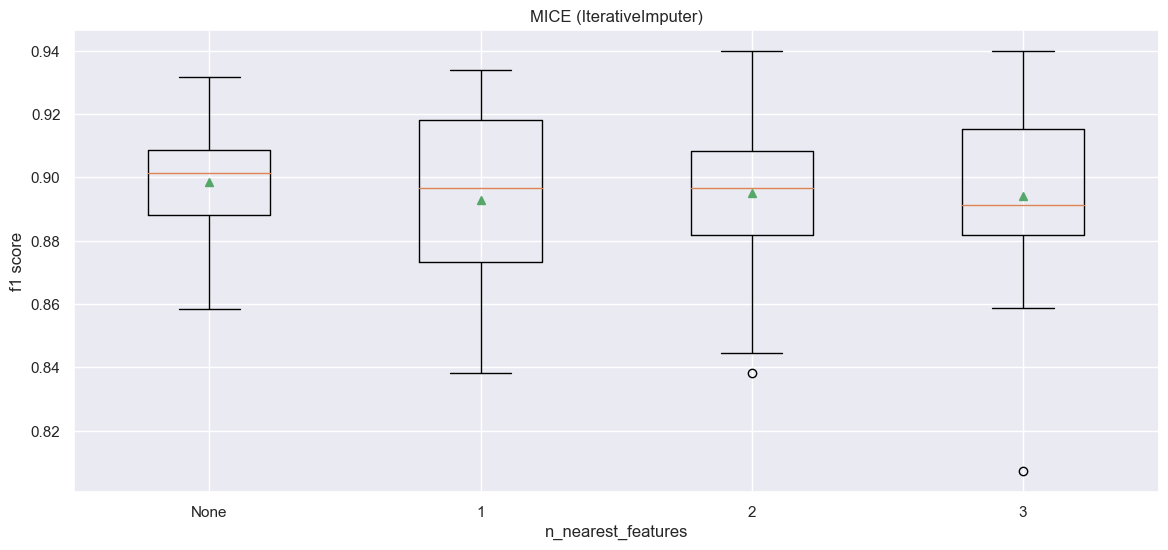

In [214]:
fig, axes = plt.subplots(1, figsize=(14, 6))
axes.boxplot(results, labels=[
             x or "None" for x in param_grid["imputer__n_nearest_features"]], showmeans=True)
axes.set_xlabel("n_nearest_features")
axes.set_ylabel("f1 score")
axes.set_title("MICE (IterativeImputer)")

In [215]:
param_idx = np.array([x.mean() for x in results]).argmax()
param_mean_acc = results[param_idx].mean()
print("Mejor Score F1 (promedio): ", param_mean_acc)

Mejor Score F1 (promedio):  0.8985048584468572


In [216]:
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(n_nearest_features=None, max_iter=1000)),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])


In [218]:
model.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   IterativeImputer(max_iter=1000)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['reports', 'age', 'income',
                                                   'share', 'expenditure',
                                                   'dependents', 'months',
                                                   'majorcards']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['owner', 'selfemp'])])),
                ('classifier', LogisticRegression())])

In [222]:
y_pred = model.predict(X_test)

In [223]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87        55
           1       0.97      0.95      0.96       183

    accuracy                           0.94       238
   macro avg       0.91      0.92      0.91       238
weighted avg       0.94      0.94      0.94       238



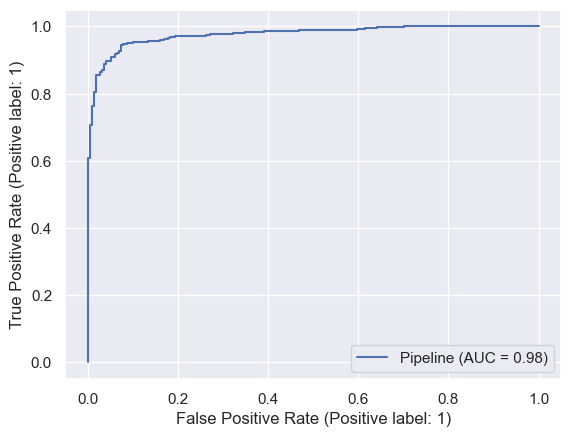

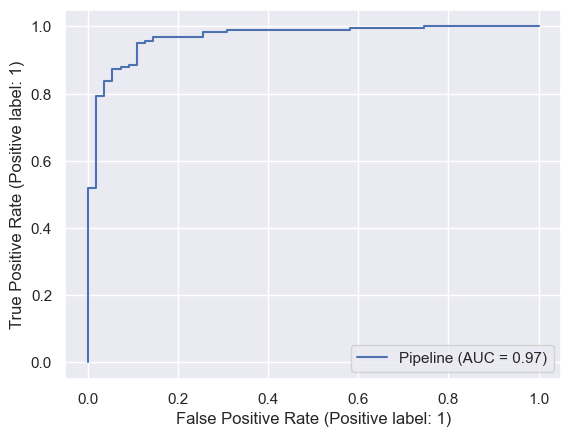

In [224]:
RocCurveDisplay.from_estimator(model, X_train, y_train)
RocCurveDisplay.from_estimator(model, X_test, y_test)